### Make a model for the RNA data

In [2]:
## Fit 5 sets of train and test data for evaluation
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import gc
import re
import csv
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import jupyterthemes.jtplot as jtplot
jtplot.style('onedork')
import warnings
warnings.filterwarnings("ignore")

def mRNAModel(X_train_vals, X_train_samps, X_train_feats, y_train, X_test_vals, X_test_samps, X_test_feats, y_test):
    meta_data = {}

    ## Make the classifier
    clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=250, max_bin=255, 
                         subsample_for_bin=50000, objective='multiclass', min_split_gain=0, min_child_weight=5, min_child_samples=10, 
                         subsample=1, subsample_freq=1, colsample_bytree=1, reg_alpha=0, reg_lambda=0, seed=0, nthread=-1, silent=False)
    ## Fit the model with the training data
    clf.fit(X_train_vals, y_train, sample_weight=None, init_score=None, eval_set=[(X_test_vals, y_test)], eval_names=None, 
            eval_sample_weight=None, eval_init_score=None, eval_metric='multi_logloss', early_stopping_rounds=10, verbose=False, 
            feature_name='auto', categorical_feature='auto')
    meta_data['model'] = clf
    # Get predictions
    meta_data['predictions'] = clf.predict(X_test_vals).tolist()
    meta_data['actual_y'] = y_test.T.values.tolist()[0]
    ## Let's see how it did
    meta_data['report'] = classification_report(y_test, meta_data['predictions'])
    ## Get feature names
    feats = X_train_feats
    feats_inds = list(range(len(feats)))
    ## Get feature importances
    imps = clf.feature_importances_
    ## Sort features and importances
    sorted_feats = list(zip(*sorted(zip(imps, feats, feats_inds), reverse = True)))[:]
    imps = list(sorted_feats[0])
    feats = list(sorted_feats[1])
    feats_inds = list(sorted_feats[2])
    meta_data['features'] = feats
    meta_data['feature_importances'] = imps
    ## Get feature inds for plotting
    meta_data['feature_indices'] = feats_inds
    ## Clear memory
    del clf, imps, feats, feats_inds, sorted_feats, X_train_vals, X_train_samps, X_train_feats, y_train, X_test_vals, X_test_samps
    del X_test_feats, y_test
    gc.collect()
    return meta_data

## Function to get data
def getData(X_filename, y_filename, use_feats):
    ## First get the dimensions of the dataset
    with open (X_filename, 'r') as f:
        csvreader_X = csv.reader(f)
        rows = -1
        for j, line in enumerate(csvreader_X):
            if j == 0:
                if len(use_feats) == 0:
                    cols = len(line[1:])
                else:
                    cols = len(use_feats)
            rows += 1
    ## Then open the dataset 
    with open (X_filename, 'r') as f:
        csvreader_X = csv.reader(f)
        X_samps = []
        X_vals = np.ndarray((rows, cols), dtype = float)
        for j, line in enumerate(csvreader_X):
            if j == 0:
                temp_feats = np.array(line[1:])
                if len(use_feats) == 0:
                    X_feats = temp_feats
                    X_feats_inds = np.array(list(range(len(temp_feats))))
                else:
                    X_feats = use_feats
                    X_feats_inds = np.array([np.where(temp_feats == x)[0].tolist()[0] for x in use_feats])
            else:
                X_samps.append(line[0])
                X_vals[j-1,:] = np.array(line[1:])[X_feats_inds.tolist()].tolist()
        X_vals[X_vals == 0] = np.nan
        X_samps = np.array(X_samps)
    ## Import y
    y = pd.read_csv(y_filename, index_col = 0)
    del temp_feats, X_feats_inds, csvreader_X, j, line
    gc.collect()
    return X_vals, X_feats, X_samps, y

## Run the classifier
def runSample(data_type, X_train_filename, y_train_filename, X_test_filename = None, y_test_filename = None, samp_ind = 1, use_feats = []):
    start_time = dt.datetime.now()
    ## Import X_train in a way that will release free memory upon gc.collect()
    X_train_vals, X_train_feats, X_train_samps, y_train = getData(X_train_filename, y_train_filename, use_feats)
    ## Get test data
    if type(X_test_filename) == str:
        X_test_vals, X_test_feats, X_test_samps, y_test = getData(X_test_filename, y_test_filename, use_feats)
    else:
        from sklearn.model_selection import train_test_split
        train_inds, test_inds = train_test_split(range(X_train_vals.shape[0]))
        X_train_vals_temp = X_train_vals
        X_train_samps_temp = X_train_samps
        y_train_temp = y_train.copy()
        del X_train_vals, X_train_samps, y_train
        gc.collect()
        X_train_vals = X_train_vals_temp[train_inds,:]
        X_test_vals = X_train_vals_temp[test_inds,:]
        X_train_samps = X_train_samps_temp[train_inds]
        X_test_samps = X_train_samps_temp[test_inds]
        X_test_feats = X_train_feats
        y_train = y_train_temp.iloc[train_inds]
        y_test = y_train_temp.iloc[test_inds]
        del X_train_vals_temp, X_train_samps_temp, y_train_temp
        gc.collect()
        
    if use_feats == []:
        feats_type = 'all_feats'
    else:
        feats_type = 'top_feats'
    meta_data = mRNAModel(X_train_vals, X_train_samps, X_train_feats, y_train, X_test_vals, X_test_samps, X_test_feats, y_test)
    print('Done in', dt.datetime.now() - start_time, 'seconds. Saving model results...')
    with open('../data/new_'+data_type+'_data_classifier_and_evaluation_data_'+str(samp_ind)+'_'+feats_type+'.pkl', 'wb') as f:
        pickle.dump(meta_data, f)
    del X_train_vals, X_train_samps, X_train_feats, X_test_vals, X_test_samps, X_test_feats, y_train, y_test
    gc.collect()
    return meta_data

## Function to get the top features and save them to a file
def getTopFeats(data_type, all_feats):
    ## Top features
    top_feats = pd.concat(all_feats, axis = 1)
    top_feats['mean_importances'] = top_feats.mean(axis = 1)
    top_feats = top_feats.mean_importances.sort_values(ascending = False)
    ## Save top features
    with open('../data/new_'+data_type+'_data_features_sorted_by_importance.pkl', 'wb') as f:
        pickle.dump(top_feats, f)
        
## Function to make top features plot
def makeTopFeatsPlot(data_type):
    ## Save top features
    with open('../data/new_'+data_type+'_data_features_sorted_by_importance.pkl', 'rb') as f:
        top_feats = pickle.load(f)
    ## Plot the top 50 most influential genes
    plt.figure(figsize = [24, 6])
    _ = plt.bar(range(50), top_feats[0:50], tick_label = top_feats.index[0:50])
    plt.xticks(range(50), top_feats.index[0:50], rotation=45, fontsize = 15, ha = 'right')
    plt.title('Top features')
    plt.show()
    
## Function to make confusion matrix plot
def makeConfusionMatrixPlot(all_y_test, all_y_preds):
    labels = sorted(list(set(all_y_test)))
    cnf = confusion_matrix(all_y_test, all_y_preds, labels = labels)
    df_cm = pd.DataFrame(cnf, index = labels, columns = labels)
    df_cm = round(100*(df_cm / df_cm.sum()), 1)
    plt.figure(figsize = (24,11))
    sns.heatmap(df_cm, annot=True, fmt = '1g', robust = True)
    plt.title('Confusion matrix with percentages (scaled by column)')
    plt.show()

## mRNA full model

Doing subset 0...
Done in 0:41:22.838220 seconds. Saving model results...
Doing subset 1...
Done in 0:42:10.001687 seconds. Saving model results...
Doing subset 2...
Done in 0:44:38.431964 seconds. Saving model results...
Doing subset 3...
Done in 0:45:46.255940 seconds. Saving model results...
Doing subset 4...
Done in 0:40:57.312749 seconds. Saving model results...
             precision    recall  f1-score   support

        ACC       0.97      0.99      0.98       142
       BLCA       0.97      0.95      0.96       664
       BRCA       0.99      0.99      0.99      2075
       CESC       0.96      0.92      0.94       501
       CHOL       0.82      0.54      0.65        78
       COAD       0.83      0.96      0.89       823
       DLBC       0.87      1.00      0.93        75
       ESCA       0.93      0.88      0.90       291
        GBM       0.99      0.96      0.98       288
       HNSC       0.97      0.98      0.97       906
       KICH       0.86      0.88      0.87    

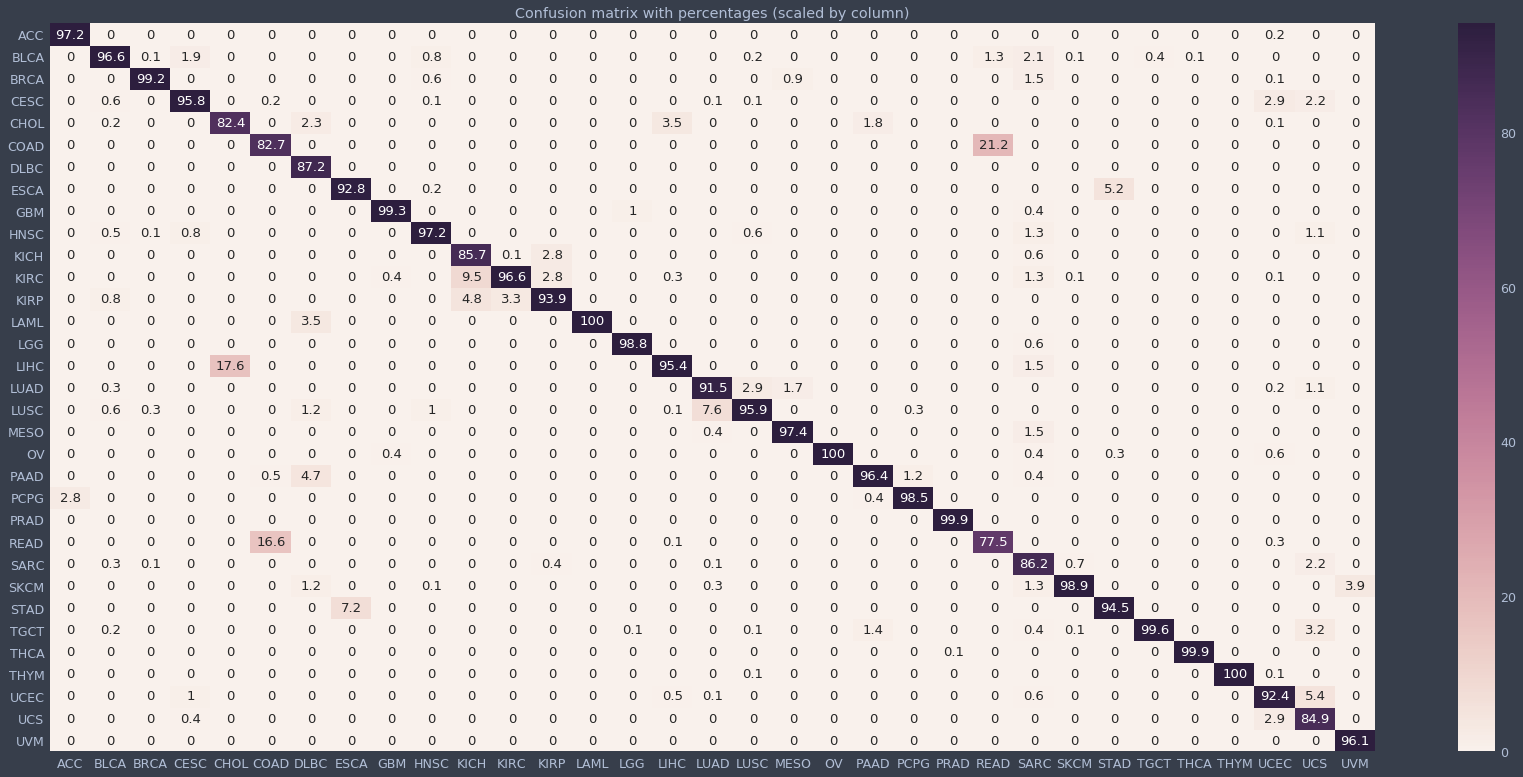

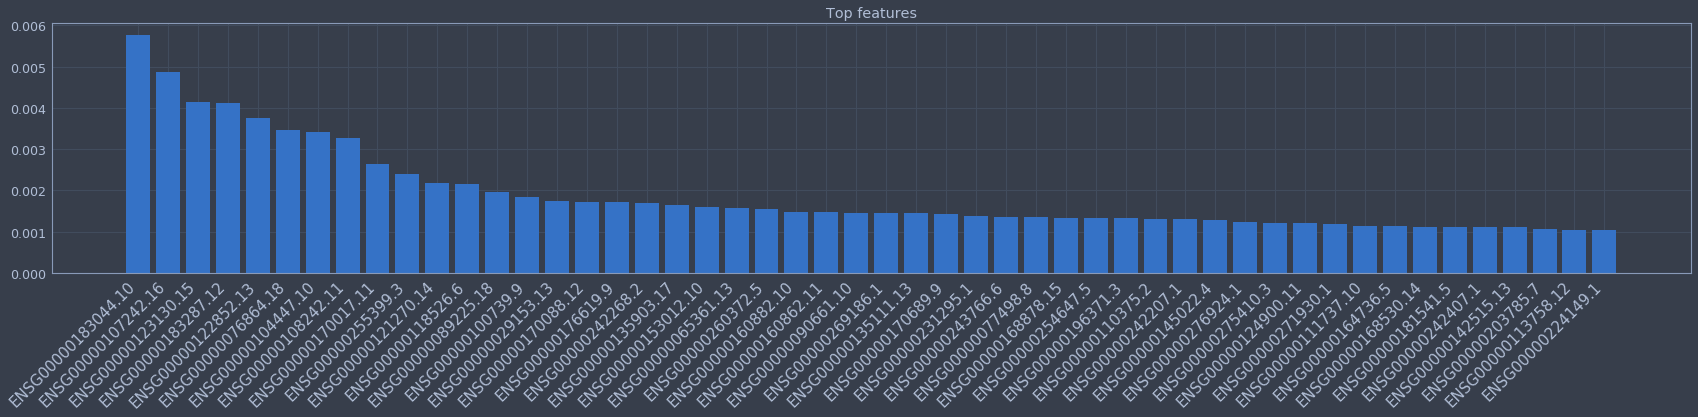

In [2]:
## Do mRNA data
all_feats = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset '+str(i)+'...')
    meta_data = runSample('mrna', '../data/new_mrna_X_train_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_train_'+str(i)+'_100_perc.csv', 
                          '../data/new_mrna_X_test_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_test_'+str(i)+'_100_perc.csv', i, [])
    feats = meta_data['features']
    imps = meta_data['feature_importances']
    df = pd.DataFrame(list(imps), index = list(feats), columns = ['importances_'+str(i)])
    all_feats.append(df)
    y_test = meta_data['actual_y']
    all_y_test += y_test
    y_preds = meta_data['predictions']
    all_y_preds += y_preds
## Get top features
getTopFeats('mrna', all_feats)
## Make plots
print(classification_report(all_y_test, all_y_preds))
makeConfusionMatrixPlot(all_y_test, all_y_preds)
makeTopFeatsPlot('mrna')

## miRNA full model

Doing subset 0...
Done in 0:01:26.928963 seconds. Saving model results...
Doing subset 1...
Done in 0:01:24.662024 seconds. Saving model results...
Doing subset 2...
Done in 0:01:24.199408 seconds. Saving model results...
Doing subset 3...
Done in 0:01:22.519696 seconds. Saving model results...
Doing subset 4...
Done in 0:01:21.868107 seconds. Saving model results...
             precision    recall  f1-score   support

        ACC       0.98      0.96      0.97        98
       BLCA       0.91      0.91      0.91       547
       BRCA       0.98      0.99      0.98      1493
       CESC       0.89      0.88      0.89       373
       CHOL       0.76      0.53      0.63        49
       COAD       0.81      0.91      0.86       628
       DLBC       0.87      0.96      0.91        72
       ESCA       0.84      0.63      0.72       276
        GBM       0.00      0.00      0.00         5
       HNSC       0.95      0.95      0.95       705
       KICH       0.88      0.88      0.88    

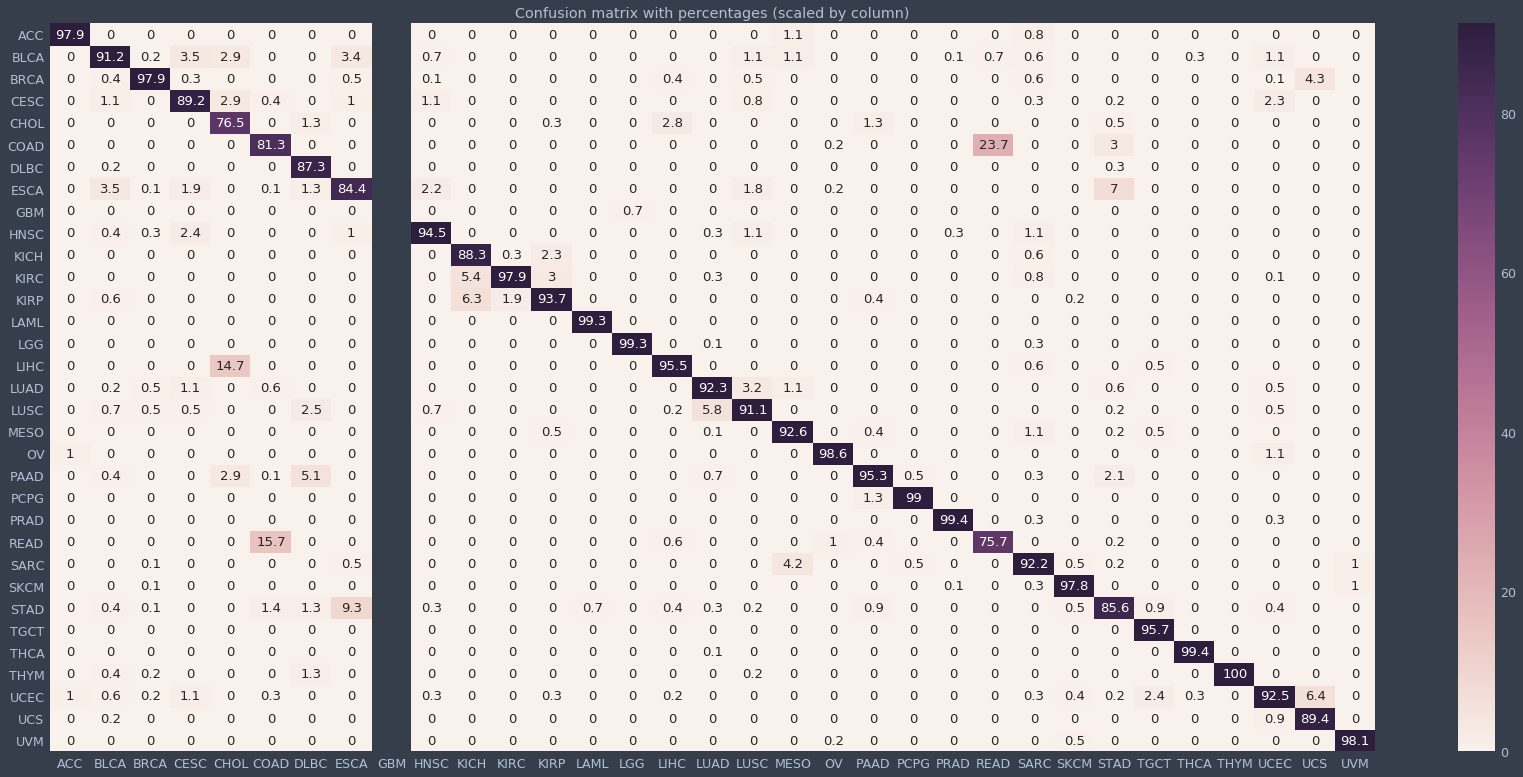

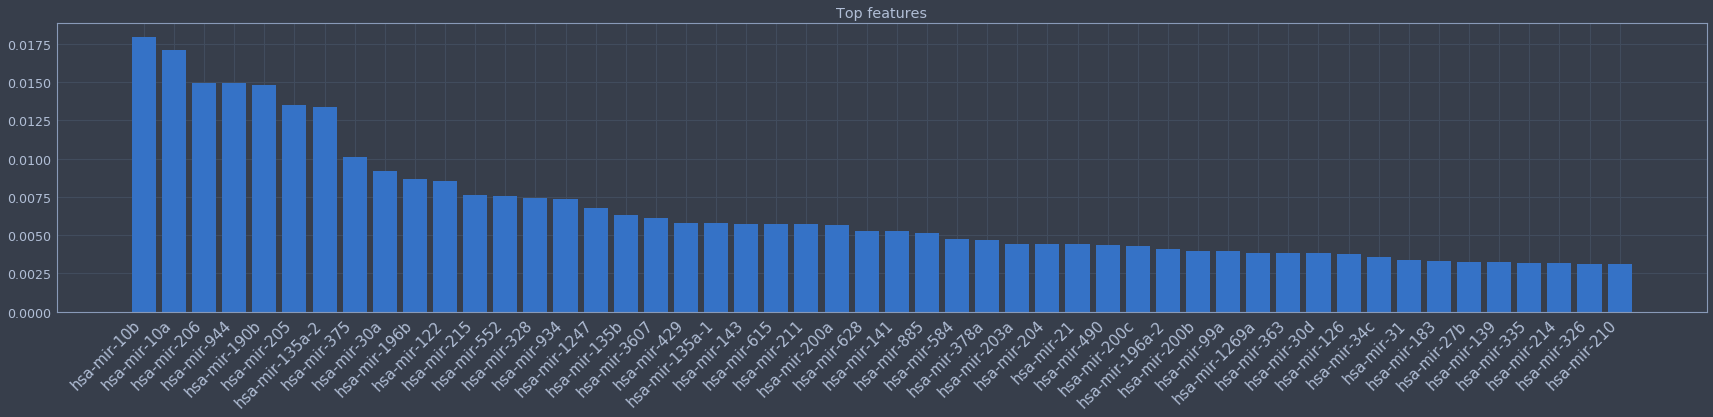

In [3]:
## Do miRNA data
all_feats = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset '+str(i)+'...')
    meta_data = runSample('mirna', '../data/new_mirna_X.csv', '../data/new_mirna_y.csv', None, None, i, [])
    feats = meta_data['features']
    imps = meta_data['feature_importances']
    df = pd.DataFrame(list(imps), index = list(feats), columns = ['importances_'+str(i)])
    all_feats.append(df)
    y_test = meta_data['actual_y']
    all_y_test += y_test
    y_preds = meta_data['predictions']
    all_y_preds += y_preds
## Get top features
getTopFeats('mirna', all_feats)
## Make plots
print(classification_report(all_y_test, all_y_preds))
makeConfusionMatrixPlot(all_y_test, all_y_preds)
makeTopFeatsPlot('mirna')

## mRNA top features model

Getting top features...
Doing subset 0...
Done in 0:03:01.014022 seconds. Saving model results...
Doing subset 1...
Done in 0:03:04.070892 seconds. Saving model results...
Doing subset 2...
Done in 0:03:08.288301 seconds. Saving model results...
Doing subset 3...
Done in 0:03:03.500541 seconds. Saving model results...
Doing subset 4...
Done in 0:03:05.107596 seconds. Saving model results...
             precision    recall  f1-score   support

        ACC       0.94      0.99      0.96       142
       BLCA       0.96      0.93      0.94       664
       BRCA       0.99      0.99      0.99      2075
       CESC       0.96      0.91      0.94       501
       CHOL       0.73      0.46      0.57        78
       COAD       0.85      0.94      0.89       823
       DLBC       0.84      0.91      0.87        75
       ESCA       0.89      0.82      0.85       291
        GBM       0.98      0.95      0.97       288
       HNSC       0.96      0.98      0.97       906
       KICH       0.78

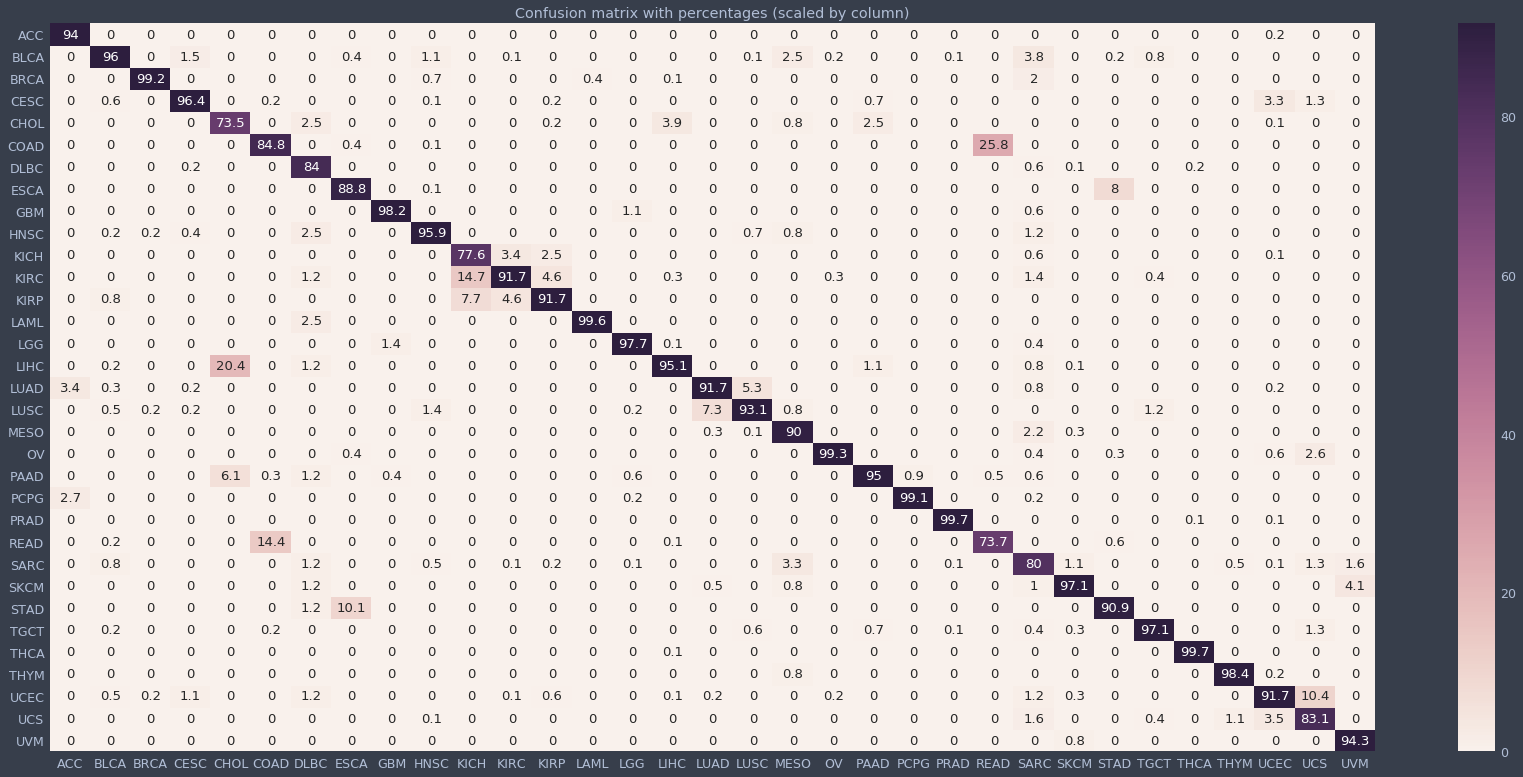

In [6]:
## Import classifier meta data
print('Getting top features...')
with open('../data/new_mrna_data_features_sorted_by_importance.pkl', 'rb') as f:
    mrna_features_sorted = pickle.load(f)

num_features = 100

## Do mRNA data
all_feats = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset '+str(i)+'...')
    meta_data = runSample('mrna', '../data/new_mrna_X_train_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_train_'+str(i)+'_100_perc.csv', 
                          '../data/new_mrna_X_test_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_test_'+str(i)+'_100_perc.csv', i, 
                          mrna_features_sorted.index.tolist()[:num_features])
    feats = meta_data['features']
    imps = meta_data['feature_importances']
    df = pd.DataFrame(list(imps), index = list(feats), columns = ['importances_'+str(i)])
    all_feats.append(df)
    y_test = meta_data['actual_y']
    all_y_test += y_test
    y_preds = meta_data['predictions']
    all_y_preds += y_preds
## Make plots
print(classification_report(all_y_test, all_y_preds))
makeConfusionMatrixPlot(all_y_test, all_y_preds)

Getting top features...
Doing subset 0...
Done in 0:16:10.356413 seconds. Saving model results...
Doing subset 1...
Done in 0:18:01.425830 seconds. Saving model results...
Doing subset 2...
Done in 0:18:42.617672 seconds. Saving model results...
Doing subset 3...
Done in 0:15:54.593310 seconds. Saving model results...
Doing subset 4...
Done in 0:19:07.763395 seconds. Saving model results...
             precision    recall  f1-score   support

        ACC       0.94      0.99      0.96       142
       BLCA       0.96      0.93      0.94       664
       BRCA       0.99      0.99      0.99      2075
       CESC       0.96      0.91      0.94       501
       CHOL       0.73      0.46      0.57        78
       COAD       0.85      0.94      0.89       823
       DLBC       0.84      0.91      0.87        75
       ESCA       0.89      0.82      0.85       291
        GBM       0.98      0.95      0.97       288
       HNSC       0.96      0.98      0.97       906
       KICH       0.78

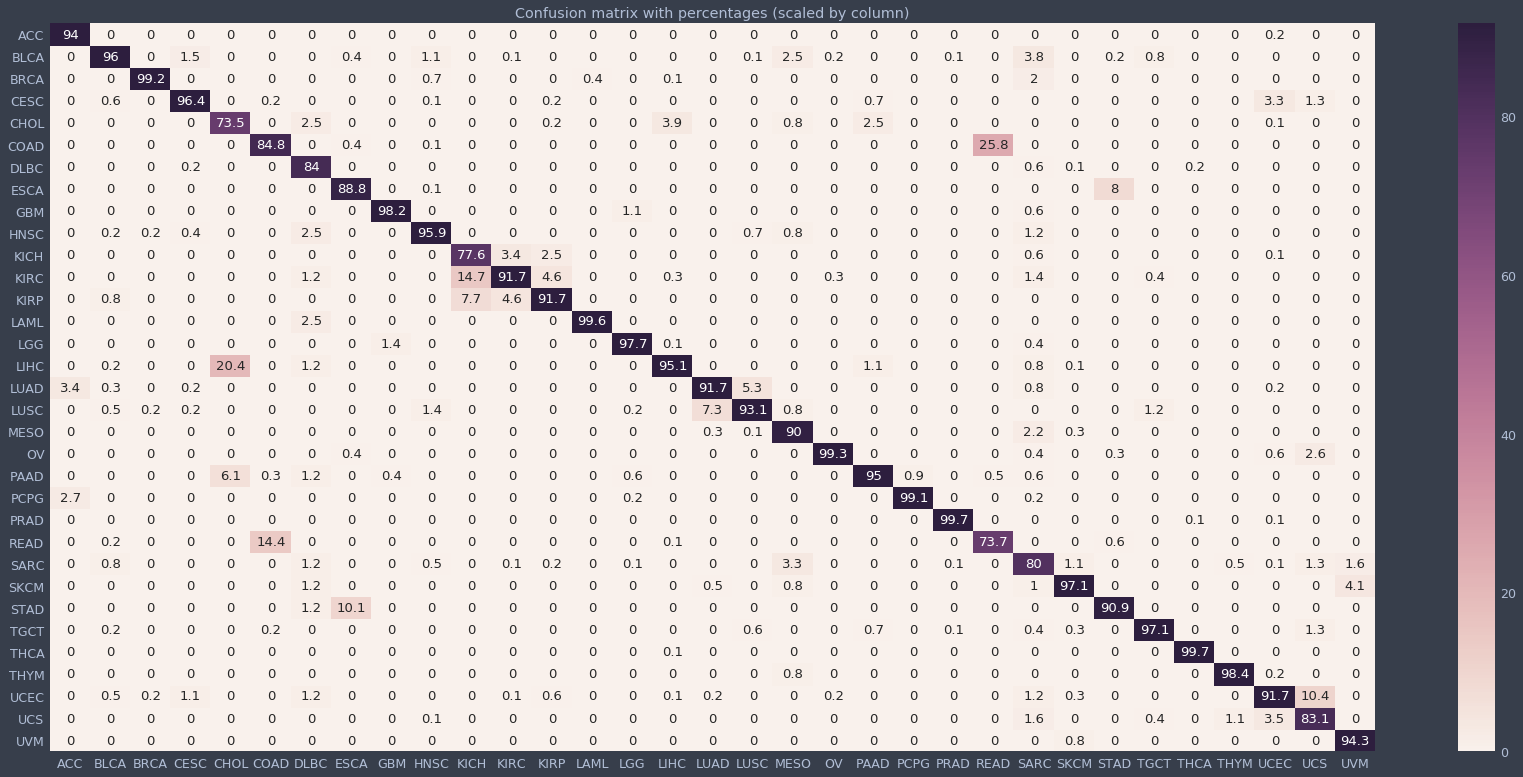

In [5]:
## Import classifier meta data
print('Getting top features...')
with open('../data/new_mrna_data_features_sorted_by_importance.pkl', 'rb') as f:
    mrna_features_sorted = pickle.load(f)

num_features = 100

## Do mRNA data
all_feats = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset '+str(i)+'...')
    meta_data = runSample('mrna', '../data/new_mrna_X_train_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_train_'+str(i)+'_100_perc.csv', 
                          '../data/new_mrna_X_test_'+str(i)+'_100_perc.csv', '../data/new_mrna_y_test_'+str(i)+'_100_perc.csv', i, 
                          mrna_features_sorted.index.tolist()[:num_features])
    feats = meta_data['features']
    imps = meta_data['feature_importances']
    df = pd.DataFrame(list(imps), index = list(feats), columns = ['importances_'+str(i)])
    all_feats.append(df)
    y_test = meta_data['actual_y']
    all_y_test += y_test
    y_preds = meta_data['predictions']
    all_y_preds += y_preds
## Make plots
print(classification_report(all_y_test, all_y_preds))
makeConfusionMatrixPlot(all_y_test, all_y_preds)

## miRNA top features model

Getting top features...
Doing subset 0...
Done in 0:00:12.805233 seconds. Saving model results...
Doing subset 1...
Done in 0:00:12.633929 seconds. Saving model results...
Doing subset 2...
Done in 0:00:12.595922 seconds. Saving model results...
Doing subset 3...
Done in 0:00:12.675057 seconds. Saving model results...
Doing subset 4...
Done in 0:00:12.532866 seconds. Saving model results...
             precision    recall  f1-score   support

        ACC       0.92      0.97      0.95       109
       BLCA       0.89      0.89      0.89       537
       BRCA       0.98      0.99      0.98      1510
       CESC       0.87      0.87      0.87       385
       CHOL       0.92      0.52      0.67        46
       COAD       0.83      0.91      0.87       584
       DLBC       0.93      0.94      0.93        53
       ESCA       0.82      0.62      0.71       267
        GBM       0.00      0.00      0.00         8
       HNSC       0.94      0.96      0.95       712
       KICH       0.89

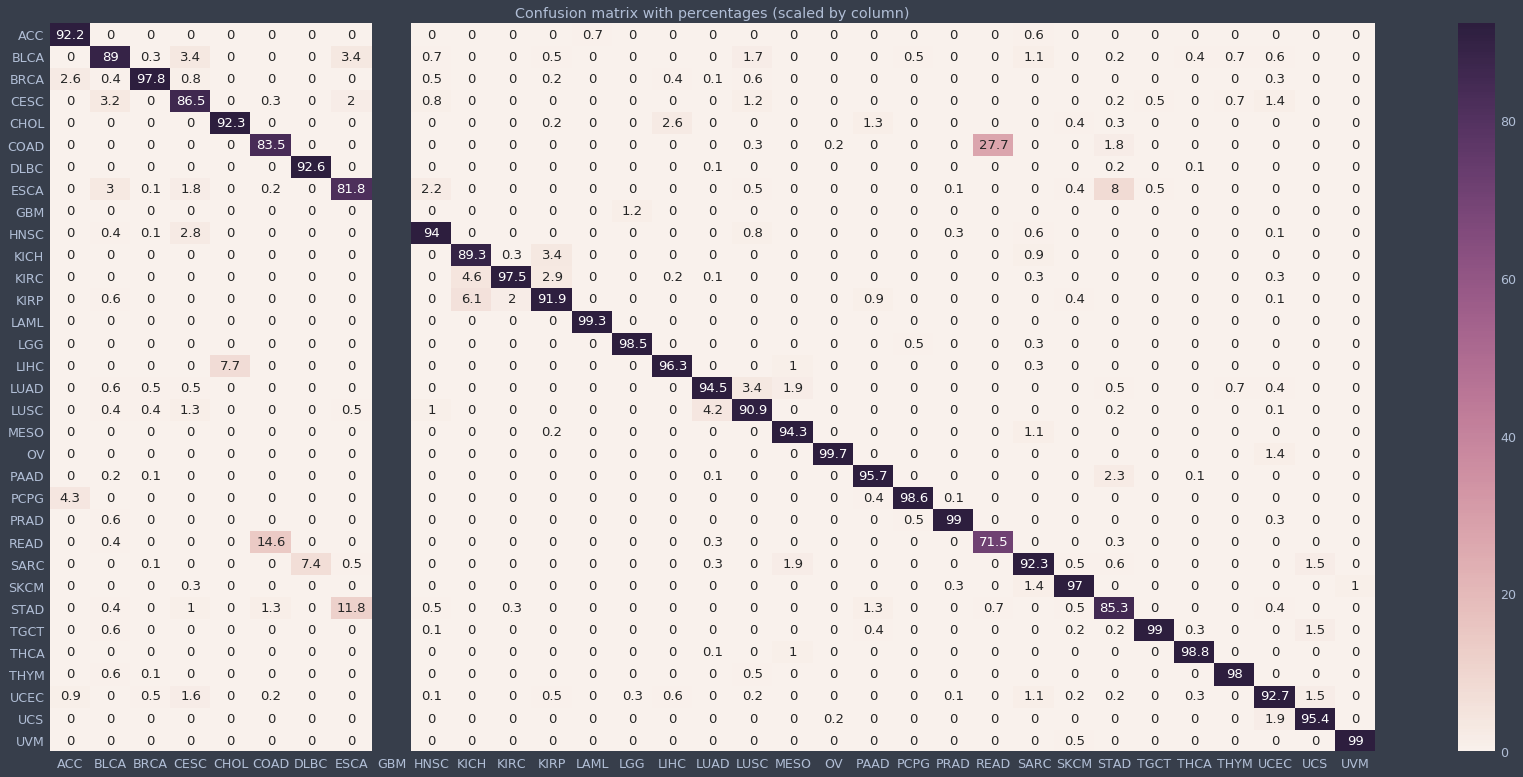

In [5]:
## Import classifier meta data
print('Getting top features...')
with open('../data/new_mirna_data_features_sorted_by_importance.pkl', 'rb') as f:
    mirna_features_sorted = pickle.load(f)

num_features = 100

## Do mirna data
all_feats = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset '+str(i)+'...')
    meta_data = runSample('mirna', '../data/new_mirna_X.csv', '../data/new_mirna_y.csv',  None, None, i, 
                          mirna_features_sorted.index.tolist()[:num_features])
    feats = meta_data['features']
    imps = meta_data['feature_importances']
    df = pd.DataFrame(list(imps), index = list(feats), columns = ['importances_'+str(i)])
    all_feats.append(df)
    y_test = meta_data['actual_y']
    all_y_test += y_test
    y_preds = meta_data['predictions']
    all_y_preds += y_preds
## Make plots
print(classification_report(all_y_test, all_y_preds))
makeConfusionMatrixPlot(all_y_test, all_y_preds)

## Combined top features model

In [6]:
import pickle
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import jupyterthemes.jtplot as jtplot
jtplot.style('onedork')
import warnings
warnings.filterwarnings("ignore")

## Import classifier meta data
print('Getting top features...')
with open('../data/new_mrna_data_features_sorted_by_importance.pkl', 'rb') as f:
    mrna_features_sorted = pickle.load(f)
with open('../data/new_mirna_data_features_sorted_by_importance.pkl', 'rb') as f:
    mirna_features_sorted = pickle.load(f)

num_mrna_features = 100
num_mirna_features = 100

tops = []
all_y_preds = []
all_y_test = []
for i in range(5):
    print('Doing subset', i)
    ## Import X and y data for mRNA-seq
    X_mrna_train = pd.read_csv('../data/new_mrna_X_train_'+str(i)+'_100_perc.csv', index_col = None, 
                               usecols = mrna_features_sorted.index.tolist()[:num_mrna_features])
    y_mrna_train = pd.read_csv('../data/new_mrna_y_train_'+str(i)+'_100_perc.csv', index_col = 0)
    X_mrna_train.index = y_mrna_train.index
    X_mrna_test = pd.read_csv('../data/new_mrna_X_test_'+str(i)+'_100_perc.csv', index_col = None, 
                              usecols = mrna_features_sorted.index.tolist()[:num_mrna_features])
    y_mrna_test = pd.read_csv('../data/new_mrna_y_test_'+str(i)+'_100_perc.csv', index_col = 0)
    X_mrna_test.index = y_mrna_test.index

    ## Import X and y data for miRNA-seq
    X_mirna = pd.read_csv('../data/new_mirna_X.csv', index_col = None, usecols = mirna_features_sorted.index.tolist()[:num_mirna_features])
    y_mirna = pd.read_csv('../data/new_mirna_y.csv', index_col = 0)
    X_mirna.index = y_mirna.index
    
    X_mirna_train, X_mirna_test, y_mirna_train, y_mirna_test = train_test_split(X_mirna, y_mirna, test_size = 0.33)

    ## Split the index into case_id and file_id
    def getCaseAndFileID(df, data_type):
        df.reset_index(inplace = True)
        df['case_id'] = df['index'].apply(lambda x: x.split('_')[0])
        df[data_type+'_file_id'] = df['index'].apply(lambda x: x.split('_')[1])
        df.drop('index', inplace = True, axis = 1)
        df.set_index('case_id', drop = True, inplace = True)
        return df

    X_mrna_train_top = getCaseAndFileID(X_mrna_train, 'mrna')
    X_mrna_test_top = getCaseAndFileID(X_mrna_test, 'mrna')
    y_mrna_train_top = getCaseAndFileID(y_mrna_train, 'mrna')
    y_mrna_test_top = getCaseAndFileID(y_mrna_test, 'mrna')
    X_mirna_train_top = getCaseAndFileID(X_mirna_train, 'mirna')
    X_mirna_test_top = getCaseAndFileID(X_mirna_test, 'mirna')
    y_mirna_train_top = getCaseAndFileID(y_mirna_train, 'mirna')
    y_mirna_test_top = getCaseAndFileID(y_mirna_test, 'mirna')

    ## Find cases common to both data sets
    common_genes_train = X_mrna_train_top.index.intersection(X_mirna_train_top.index).unique()
    common_genes_test = X_mrna_test_top.index.intersection(X_mirna_test_top.index).unique()

    ## Find intersection of mRNA and miRNA samples
    X_train_top = X_mrna_train_top.join(X_mirna_train_top, how = 'outer', sort = False)
    y_train_top = y_mrna_train_top.join(y_mirna_train_top, how = 'outer', sort = False, lsuffix='_mrna', rsuffix='_mirna')
    X_test_top = X_mrna_test_top.join(X_mirna_test_top, how = 'outer', sort = False)
    y_test_top = y_mrna_test_top.join(y_mirna_test_top, how = 'outer', sort = False, lsuffix='_mrna', rsuffix='_mirna')

    ## Fix nan values in y data
    y_train_top['y'] = y_train_top[['y_mrna', 'y_mirna']].apply(lambda x: str(x[0]) if str(x[0]) != 'nan' else str(x[1]), axis = 1)
    y_train_top.drop(['y_mrna', 'y_mirna'], axis = 1, inplace = True)
    y_test_top['y'] = y_test_top[['y_mrna', 'y_mirna']].apply(lambda x: str(x[0]) if str(x[0]) != 'nan' else str(x[1]), axis = 1)
    y_test_top.drop(['y_mrna', 'y_mirna'], axis = 1, inplace = True)

    ## Get indices right
    def fixIndices(df):
        df.reset_index(inplace = True)
        df['new_index'] = df['case_id'].astype(str)+'_'+df['mrna_file_id'].astype(str)+'_'+df['mirna_file_id'].astype(str)
        df.set_index('new_index', drop = True, inplace = True)
        df.drop(['mrna_file_id', 'mirna_file_id', 'case_id'], axis = 1, inplace = True)
        return df

    X_train_top = fixIndices(X_train_top)
    y_train_top = fixIndices(y_train_top)
    X_test_top = fixIndices(X_test_top)
    y_test_top = fixIndices(y_test_top)

    X_train_top.replace(0, np.nan, inplace = True)
    X_test_top.replace(0, np.nan, inplace = True)

    ## Make the classifier
    clf_top = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=250, max_bin=255, 
                             subsample_for_bin=50000, objective='multiclass', min_split_gain=0, min_child_weight=5, min_child_samples=10, 
                             subsample=1, subsample_freq=1, colsample_bytree=1, reg_alpha=0, reg_lambda=0, seed=0, nthread=-1, 
                             silent=False)
    ## Fit the model with the training data
    clf_top.fit(X_train_top, y_train_top, sample_weight=None, init_score=None, eval_set=[(X_test_top, y_test_top)], eval_names=None, 
                eval_sample_weight=None, eval_init_score=None, eval_metric='multi_logloss', early_stopping_rounds=15, verbose=False, 
                feature_name='auto', categorical_feature='auto')

    ## Get predictions
    preds_top = clf_top.predict(X_test_top)
    all_y_preds += preds_top.tolist()
    all_y_test += y_test_top.T.values.tolist()[0]
    ## Get feature names
    feats_top = X_train_top.columns
    ## Get feature importances
    imps_top = clf_top.feature_importances_
    tops.append(sorted(zip(imps_top, feats_top), reverse = True))
    meta_data = {'actual_y': all_y_test, 'predictions': all_y_preds}
    with open('../data/new_combined_model_data_classifier_and_evaluation_data_'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(meta_data, f)

Getting top features...
Doing subset 0
Doing subset 1
Doing subset 2
Doing subset 3
Doing subset 4


             precision    recall  f1-score   support

        ACC       0.94      0.95      0.94       228
       BLCA       0.93      0.92      0.92      1129
       BRCA       0.98      0.99      0.99      3344
       CESC       0.93      0.87      0.90       856
       CHOL       0.69      0.44      0.54       120
       COAD       0.82      0.91      0.86      1341
       DLBC       0.90      0.93      0.92       120
       ESCA       0.80      0.71      0.75       510
        GBM       0.95      0.94      0.95       294
       HNSC       0.95      0.98      0.96      1529
       KICH       0.82      0.79      0.80       243
       KIRC       0.95      0.95      0.95      1657
       KIRP       0.91      0.91      0.91       901
       LAML       0.99      1.00      1.00       361
        LGG       0.99      0.99      0.99      1510
       LIHC       0.95      0.98      0.96      1164
       LUAD       0.91      0.93      0.92      1574
       LUSC       0.92      0.89      0.91   

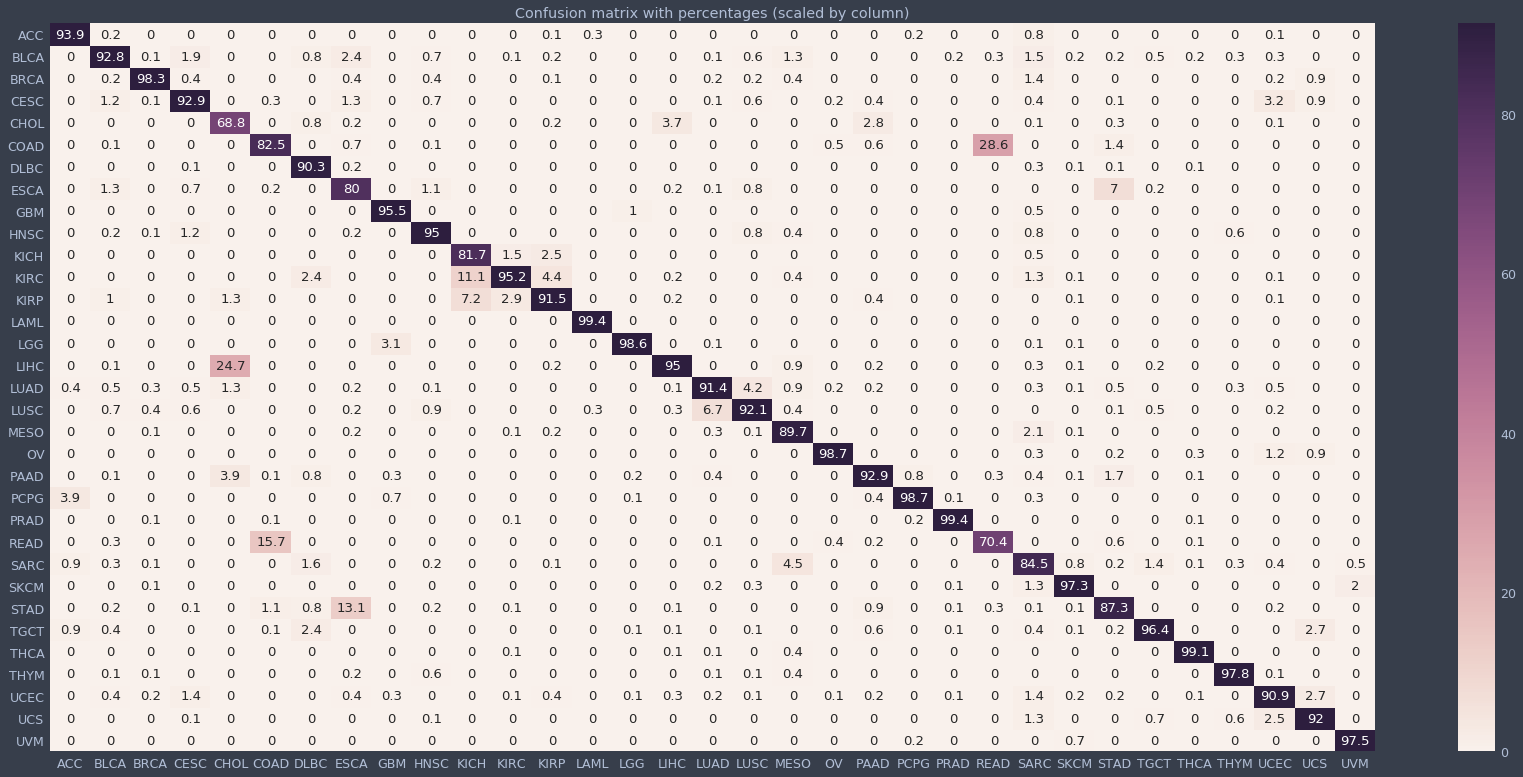

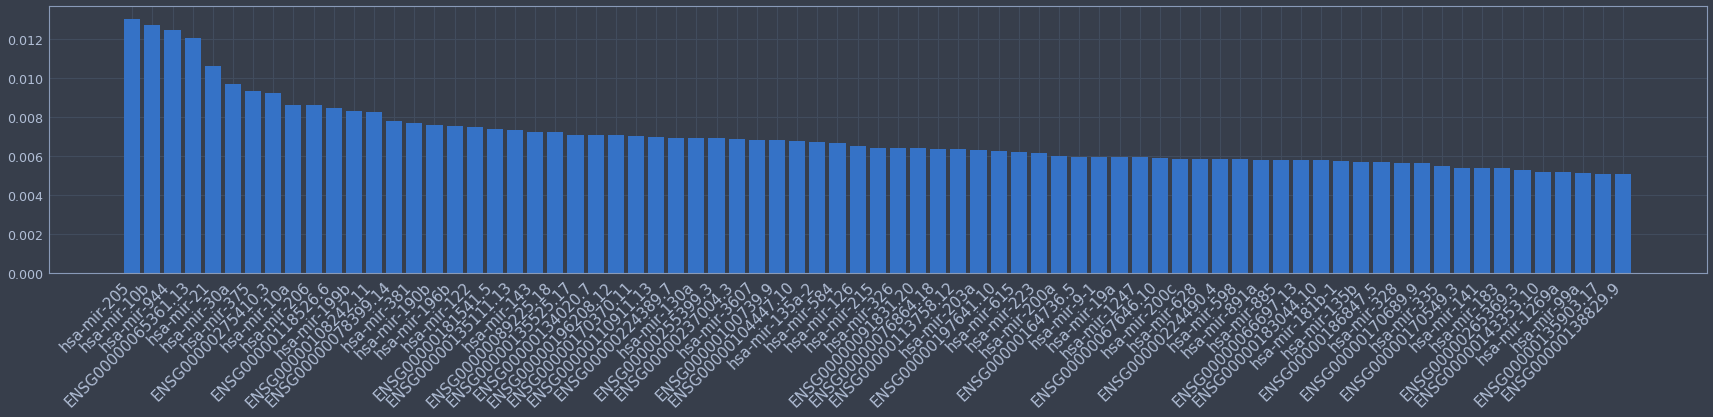

In [7]:
## Master classification report
print(classification_report(all_y_test, all_y_preds))
## Make confusion matrix plot
makeConfusionMatrixPlot(all_y_test, all_y_preds)
## Make top features plot
dfs = []
for i, each in enumerate(tops):
    df =(pd.DataFrame(each, columns = ['importances_'+str(i), 'feature']))
    df.set_index('feature', drop = True, inplace = True)
    dfs.append(df)
top_feats = pd.concat(dfs, axis = 1)
top_feats['mean_importances'] = top_feats.mean(axis = 1)
top_feats = top_feats.mean_importances.sort_values(ascending = False)

## Plot the top 50 most influential genes
plt.figure(figsize = [24, 6])
num_features = 75
_ = plt.bar(range(num_features), top_feats[:num_features], tick_label = top_feats.index[:num_features])
plt.xticks(range(num_features), top_feats.index[:num_features], rotation=45, fontsize = 15, ha = 'right')
plt.show()

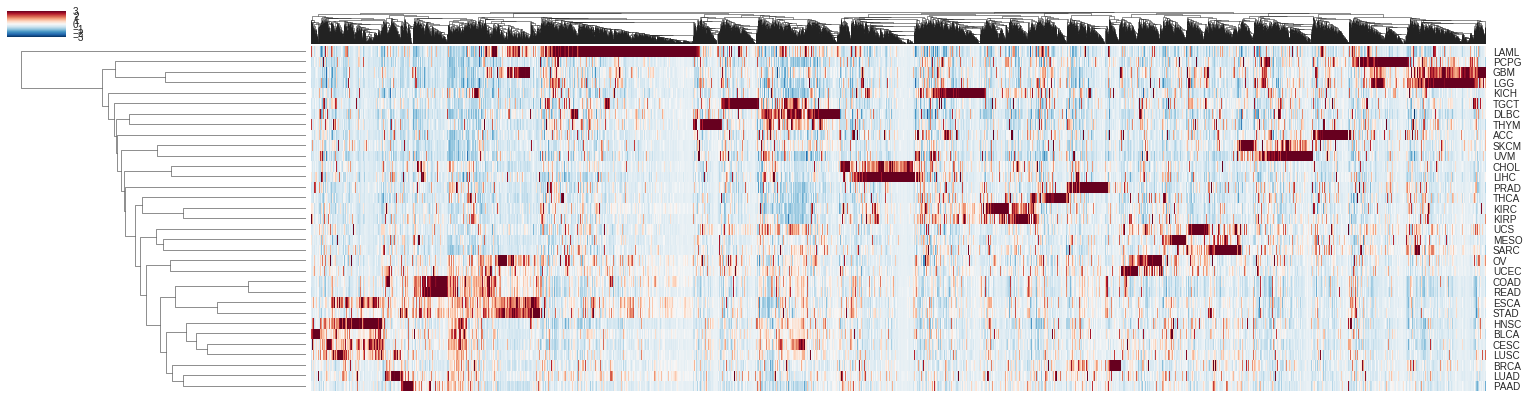

In [15]:
## Do some hierarchical clustering on the top 1000 features from just mRNA
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()

num_features = 10000

## Import the data
X_mrna_train = pd.read_csv('../data/new_mrna_X_train_0_100_perc.csv', index_col = None, 
                           usecols = mrna_features_sorted.index.tolist()[:num_features])
y_mrna_train = pd.read_csv('../data/new_mrna_y_train_0_100_perc.csv', index_col = 0)
X_mrna_train.index = y_mrna_train.index
X_mrna_test = pd.read_csv('../data/new_mrna_X_test_0_100_perc.csv', index_col = None, 
                          usecols = mrna_features_sorted.index.tolist()[:num_features])
y_mrna_test = pd.read_csv('../data/new_mrna_y_test_0_100_perc.csv', index_col = 0)
X_mrna_test.index = y_mrna_test.index
## Combine the train and test data into one
X_mrna = pd.concat([X_mrna_train, X_mrna_test], axis = 0)
y_mrna = pd.concat([y_mrna_train, y_mrna_test], axis = 0)

## Set the cancer type as the index
X_mrna.index = y_mrna.T.values.tolist()
## Group by index and take an average of each type of cancer
X_mrna_means = X_mrna.replace(0, np.nan).groupby(level = 0).mean()   
## Scale the data
X_mrna_scl = scl.fit_transform(X_mrna_means.replace(np.nan, 0))
X_mrna_scl = pd.DataFrame(X_mrna_scl, index = X_mrna_means.index, columns = X_mrna_means.columns)
## Save data for use in results notebook
X_mrna_scl.to_csv('../data/mrna_top_10000_feats_average_data_for_clustering.csv')
## Plot the clustermap
sns.set(font_scale=1)
g = sns.clustermap(X_mrna_scl.replace(np.nan, 0), figsize = (26.5, 7), vmin = -3, vmax = 3, xticklabels = False)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

## Cancer type abbreviation key

ACC, Adrenocortical Carcinoma

BLCA, Bladder Urothelial Carcinoma

BRCA, Breast Invasive Carcinoma

CESC, Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma

CHOL, Cholangiocarcinoma

COAD, Colon Adenocarcinoma

DLBC, Lymphoid Neoplasm Diffuse Large B-cell Lymphoma

ESCA, Esophageal Carcinoma

GBM, Glioblastoma Multiforme

HNSC, Head and Neck Squamous Cell Carcinoma

KICH, Kidney Chromophobe

KIRC, Kidney Renal Clear Cell Carcinoma

KIRP, Kidney Renal Papillary Cell Carcinoma

LAML, Acute Myeloid Leukemia

LIHC, Liver Hepatocellular Carcinoma

LLG, Brain Lower Grade Glioma

LUAD, Lung Adenocarcinoma

LUSC, Lung Squamous Cell Carcinoma

MESO, Mesothelioma

OV, Ovarian Serous Cystadenocarcinoma

PAAD, Pancreatic Adenocarcinoma

PCPG, Pheochromocytoma and Paraganglioma

PRAD, Prostate Adenocarcinoma

READ, Rectum Adenocarcinoma

SARC, Sarcoma

SKCM, Skin Cutaneous Melanoma

STAD, Stomach Adenocarcinoma

TGCT, Testicular Germ Cell Tumors

THCA, Thyroid Carcinoma

THYM, Thymoma

UCEC, Uterine Corpus Endometrial Carcinoma

UCS, Uterine Carcinosarcoma

UVM, Uveal Melanoma